In [96]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import svm, metrics, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix

from skimage.io import imread
from skimage.transform import resize

import pandas as pd
import seaborn as sn

In [97]:
def load_image_files(container_path, dimension=(64, 64)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = imread(file)
            img_resized = resize(img, dimension, mode='reflect')
            flat_data.append(img_resized.flatten()) 
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [98]:
image_dataset = load_image_files("images/")

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.2,random_state=109)

## SVM Classifier

In [104]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
svm_model = GridSearchCV(svc, param_grid)
svm_model.fit(X_train, y_train)
acc_svm = svm_model.score(X_test, y_test)
print("histogram accuracy: {:.2f}%".format(acc_svm * 100))

histogram accuracy: 85.56%


In [105]:
y_svm_pred = svm_model.predict(X_test)

In [106]:
print("Classification report for - \n{}:\n{}\n".format(
    svm_model, metrics.classification_report(y_test, y_svm_pred)))

Classification report for - 
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0):
             precision    recall  f1-score   support

          0       0.93      0.84      0.88        44
          1       0.81      0.91      0.86        33
          2       0.77      0.77      0.77        13

avg / total       0.86      0.86      0.86        90




## KNN Classification

In [107]:
knn_model = KNeighborsClassifier(n_neighbors=1,
                             n_jobs=-1)
knn_model.fit(X_train, y_train)
acc_knn = knn_model.score(X_test, y_test)
print("histogram accuracy: {:.2f}%".format(acc_knn * 100))

histogram accuracy: 74.44%


In [108]:
y_knn_pred = knn_model.predict(X_test)

In [109]:
print("Classification report for - \n{}:\n{}\n".format(
    knn_model, metrics.classification_report(y_test, y_knn_pred)))

Classification report for - 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform'):
             precision    recall  f1-score   support

          0       0.80      0.73      0.76        44
          1       0.64      0.76      0.69        33
          2       0.91      0.77      0.83        13

avg / total       0.76      0.74      0.75        90




## Plot Confustion Matrices

In [110]:
lbls = ['walking', 'running', 'chair']

conf_svm = confusion_matrix(y_test, y_svm_pred)
conf_knn = confusion_matrix(y_test, y_knn_pred)

[]

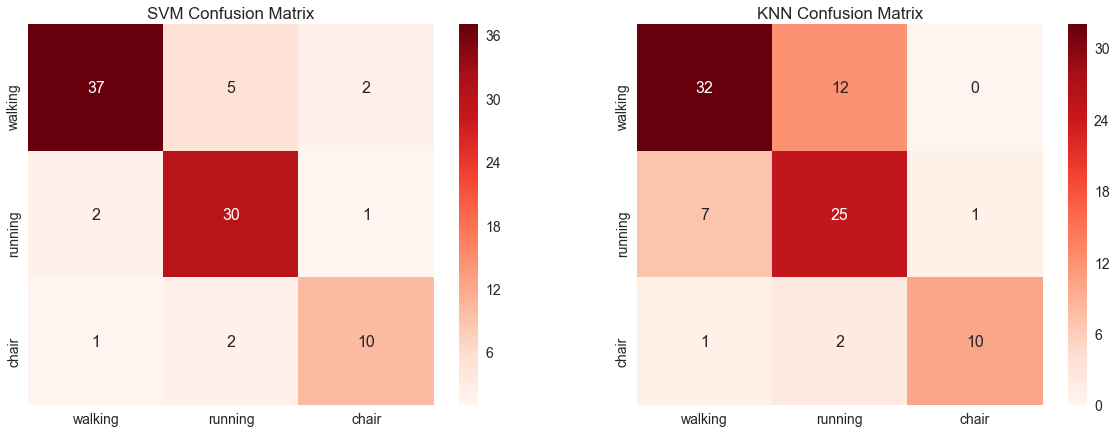

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

df_cm_svm = pd.DataFrame(conf_svm, index=lbls, columns=lbls)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_svm, annot=True, annot_kws={"size": 16}, cmap="Reds", ax=ax1).set_title("SVM Confusion Matrix")

df_cm_knn = pd.DataFrame(conf_knn, index=lbls, columns=lbls)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_knn, annot=True, annot_kws={"size": 16}, cmap="Reds", ax=ax2).set_title("KNN Confusion Matrix")

plt.plot()

## Summary

With the same train and test data, SVM was able to obtain 86% accuracy whereas KNN obtained 78% accuracy.

Based simply on these scores, one would assume that SVM performed better. However, there are 3 categories being classified; person running, person walking, and a chair rolling. In our problem space, we want to be able to determine whether or not a person is in the frame, therefore the person running and person walking categories should actually be combined into one. When we take this into account, we can see from the confusion matrix that the KNN was incorrectly classifying the person running as a person walking and vice versa -- which in our case is actually a good thing. It is identifying that the images containing a person are related. Whereas the SVM is slightly leaning towards grouping the people but not to as great a degree. This is indicitive that SVM is slightly overfitting to the training data and would not be as good at generalizing. 

## Extreme Learning Machine (ELM)

In [90]:
import elm

In [91]:
targ = np.array(image_dataset.target)
targ = targ.reshape(450, 1)
dat = np.array(image_dataset.data)

data_with_labels = np.concatenate((targ, dat), axis=1)
tr_set, te_set = elm.split_sets(data_with_labels, training_percent=0.8, perm=True)

In [92]:
elmk = elm.ELMKernel()
elmk.search_param(data_with_labels, cv="kfold", of="accuracy", eval=10)

tr_result = elmk.train(tr_set)
te_result = elmk.test(te_set)
print("Accuracy: ", te_result.get_accuracy())

elmk
##### Start search #####


/Users/Ayden/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/Ayden/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Kernel function:  rbf  best cv value:  0.4444444444444444
Kernel function:  linear  best cv value:  0.7822222222222222
Kernel function:  poly  best cv value:  0.7311111111111112
##### Search complete #####

Regressor Parameters

Regularization coefficient:  -0.7763650393478788
Kernel Function:  linear
Kernel parameters:  []

CV error:  0.7822222222222222

0.8


In [120]:
pred_elm = te_result.predicted_targets.copy()
for i, x in enumerate(pred_elm):
    if x <= 0.5:
        pred_elm[i] = 0
    elif x <= 1.5:
        pred_elm[i] = 1
    else:
        pred_elm[i] = 2

[]

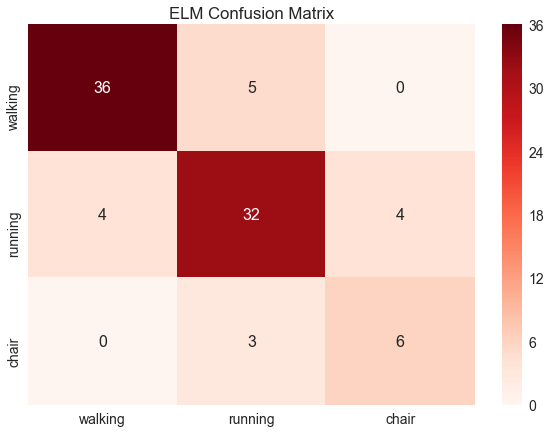

In [122]:
lbls = ['walking', 'running', 'chair']

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

conf_elm = confusion_matrix(te_result.expected_targets, pred_elm)
df_cm_elm = pd.DataFrame(conf_elm, index=lbls, columns=lbls)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_elm, annot=True, annot_kws={"size": 16}, cmap="Reds", ax=ax1).set_title("ELM Confusion Matrix")

plt.plot()

## Comparing All 3 Models

[]

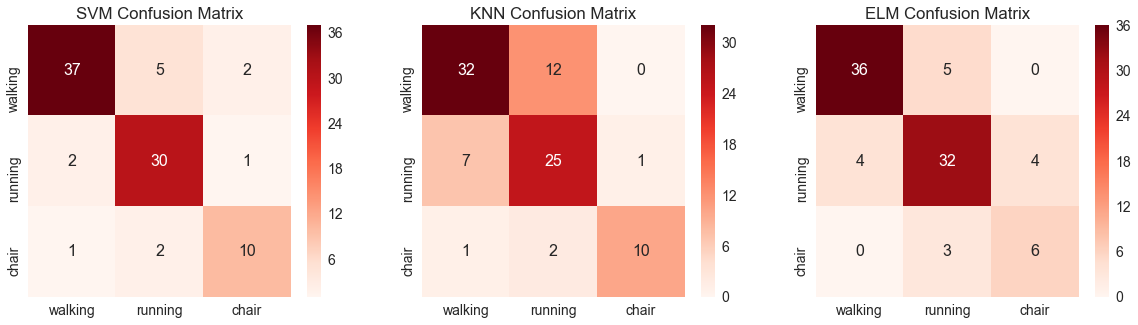

In [117]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

df_cm_svm = pd.DataFrame(conf_svm, index=lbls, columns=lbls)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_svm, annot=True, annot_kws={"size": 16}, cmap="Reds", ax=ax1).set_title("SVM Confusion Matrix")

df_cm_knn = pd.DataFrame(conf_knn, index=lbls, columns=lbls)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_knn, annot=True, annot_kws={"size": 16}, cmap="Reds", ax=ax2).set_title("KNN Confusion Matrix")

df_cm_elm = pd.DataFrame(conf_elm, index=lbls, columns=lbls)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_elm, annot=True, annot_kws={"size": 16}, cmap="Reds", ax=ax3).set_title("ELM Confusion Matrix")

plt.plot()

### References


svm: https://github.com/whimian/SVM-Image-Classification/blob/master/Image%20Classification%20using%20scikit-learn.ipynb

knn: https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/

elm: https://readthedocs.org/projects/elm/downloads/pdf/latest/